In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use("ggplot")
from textwrap import wrap
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import Counter
import string
import nltk
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

from datasets import load_dataset


/Users/theodore/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [107]:
# huggin face dataset
dataset1 = load_dataset("artem9k/ai-text-detection-pile")

df1 = pd.DataFrame(dataset1['train'].to_pandas())
df1 = df1[['text','source']]
df1['source'] = df1['source'].map({'human': 0, 'ai': 1})

# LLM-Detect-AI-Generated-Text
dataset2 = pd.read_csv('LLM-Detect-AI-Generated-Text.csv')

df2 = dataset2[['text','generated']]
df2 = df2.rename(columns={'generated': 'source'})  
df2['source'] = df2['source'].map({0: 0, 1: 1})

# PaLm-Generated-Essays
dataset3 = pd.read_csv('PaLm-Generated-Essays.csv')
df3 = dataset3[['text','generated']]
df3 = df3.rename(columns={'generated': 'source'})  
df3['source'] = df3['source'].map({0.0: 0, 1.0: 1})

# Combined-Set-test
dataset4 = pd.read_csv('Combined-Set-test.csv')
df4 = dataset4[['text','label']]
df4 = df4.rename(columns={'label': 'source'})  
df4['source'] = df4['source'].map({0: 0, 1: 1})

# Combined-Set-train
dataset5 = pd.read_csv('Combined-Set-train.csv')
df5 = dataset5[['text','label']]
df5 = df5.rename(columns={'label': 'source'})  
df5['source'] = df5['source'].map({0: 0, 1: 1})

# AI-vs-Human-Text
dataset6 = pd.read_csv('AI-vs-Human-Text.csv')
df6 = dataset6[['text','generated']]
df6 = df6.rename(columns={'generated': 'source'})  
df6['source'] = df6['source'].map({0.0: 0, 1.0: 1})

# ArguGPT
dataset7 = pd.read_csv('argugpt.csv')
df7 = dataset7[['text']]
df7['source'] = 1

dataset8 = pd.read_csv('machine-train.csv')
df8 = dataset8[['text']]
df8['source'] = 1

dataset9 = pd.read_csv('machine-test.csv')
df9 = dataset9[['text']]
df9['source'] = 1

dataset10 = pd.read_csv('machine-dev.csv')
df10 = dataset10[['text']]
df10['source'] = 1
print(df10)

# Human-vs-LLM-Corpus-Bloom-7B-and-GPT 
dataset11 = pd.read_csv('Human-vs-LLM-Corpus-Bloom-7B-and-GPT.csv')
df11 = dataset11[['text','source']]
df11['source'] = df11['source'].apply(lambda x: 0 if x == 'Human' else 1)
print(df11)

# Combine all dataframes into one
#df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11], ignore_index=True)

#print(df)




/var/folders/7_/v74xm1tn6zn5xx52z3f4_9b40000gn/T/ipykernel_73233/3119361798.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['source'] = 1
/var/folders/7_/v74xm1tn6zn5xx52z3f4_9b40000gn/T/ipykernel_73233/3119361798.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['source'] = 1
/var/folders/7_/v74xm1tn6zn5xx52z3f4_9b40000gn/T/ipykernel_73233/3119361798.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

                                                  text  source
0    There are a variety of opinions on the purpose...       1
1    The university education is not only for prepa...       1
2    I believe that the university education is mor...       1
3    University education is a topic of much debate...       1
4    The purpose of university education has been a...       1
..                                                 ...     ...
345  The notion that one must be forced to defend a...       1
346  I strongly agree with the statement that menta...       1
347  In today’s world, where competition is highly ...       1
348  Education is one of the most powerful tools th...       1
349  As the world is evolving rapidly, the need for...       1

[350 rows x 2 columns]
                                                     text  source
0       Federal law supersedes state law, and cannabis...       1
1       Miles feels restless after working all day. He...       1
2       So first of I 

/var/folders/7_/v74xm1tn6zn5xx52z3f4_9b40000gn/T/ipykernel_73233/3119361798.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df11['source'] = df11['source'].apply(lambda x: 0 if x == 'Human' else 1)


In [113]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11], ignore_index=True)

In [3]:
# using m1 mac
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [114]:
print(df)



                                                      text  source
0        12 Years a Slave: An Analysis of the Film Essa...       0
1        20+ Social Media Post Ideas to Radically Simpl...       0
2        2022 Russian Invasion of Ukraine in Global Med...       0
3        533 U.S. 27 (2001) Kyllo v. United States: The...       0
4        A Charles Schwab Corporation Case Essay\n\nCha...       0
...                                                    ...     ...
3140843  \nIn the vast expanse of time, where the echoe...       1
3140844  \nThe phenomenon of brain drain, particularly ...       1
3140845  \nThe Influence of Climate Change on Marine Ec...       1
3140846  \nTitle: The Case for Limiting Car Usage: Navi...       1
3140847  \nIn the vast expanse of a globalized society,...       1

[3140848 rows x 2 columns]


In [5]:
# 60% Training, 20% Validation, 20% Test
#train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)  
#valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  

#print("Training set size:", len(train_df))
#print("Validation set size:", len(valid_df))
#print("Test set size:", len(test_df))

In [115]:
#df = df.sample(n=2000, random_state=1)
df0_text = df[df['source'] == 0].copy()
df1_ai = df[df['source'] == 1].copy()

train_df = pd.concat([df0_text,df1_ai], ignore_index=True)

print("Data set size size:", len(train_df))

Data set size size: 3140848


In [7]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/theodore/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/theodore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/theodore/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [116]:
from tqdm.notebook import tqdm
from collections import Counter
import string

porter = PorterStemmer()

# establish stop words and linking words
stop_words = set(stopwords.words('english'))
linking_words = {'to', 'the', 'and', 'of', 'in', 'on', 'for', 'with', 'at', 'a', 'an'}

# sentiment analyzer
sid = SentimentIntensityAnalyzer()

###
all_words = []

# Function to tokenize text and remove stopwords
def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in linking_words]
    return tokens

# Tokenize all texts and add to all_words
df0_text['text'].apply(lambda text: all_words.extend(tokenize_text(text)))
df1_ai['text'].apply(lambda text: all_words.extend(tokenize_text(text)))

# Count word occurrences
word_counts = Counter(all_words)

# Select the top 500 most common words as features
top_words = [word for word, _ in word_counts.most_common(500)]


def analyze_text(text):
    tokens = word_tokenize(text)
    
    linking_words_count = sum(token in linking_words for token in tokens)
        
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in linking_words]
    counts = Counter(text)
    token_length = len(tokens)
    
    word_features = [1 if word in tokens else 0 for word in top_words]
    punctuation_count = sum(counts[char] for char in string.punctuation)
    sentiment_scores = sid.polarity_scores(text)
    punctuation_count_percentage = punctuation_count / token_length * 100 if token_length != 0 else 0
    linking_words_count_percentage = linking_words_count / token_length * 100 if token_length != 0 else 0
    
    return pd.Series([token_length, sentiment_scores['compound'], punctuation_count, linking_words_count, word_features, punctuation_count_percentage, linking_words_count_percentage])

# Convert 'text' column to lowercase for df0_text and df1_ai
df0_text['text'] = df0_text['text'].str.lower()
df1_ai['text'] = df1_ai['text'].str.lower()

# Select the top 500 most common words as features
top_words = [word for word, _ in word_counts.most_common(500)]

# Apply the analyze_text function to the 'text' column
tqdm.pandas(desc="Processing df0_text")
df0_text[['text_length', 'sentiment_score', 'punctuation_count', 'linking_words_count', 'word_features', 'punctuation_count_percentage', 'linking_words_count_percentage']] = df0_text['text'].progress_apply(analyze_text)

tqdm.pandas(desc="Processing df1_ai")
df1_ai[['text_length', 'sentiment_score', 'punctuation_count', 'linking_words_count', 'word_features', 'punctuation_count_percentage', 'linking_words_count_percentage']] = df1_ai['text'].progress_apply(analyze_text)

Processing df0_text:   0%|          | 0/1977142 [00:00<?, ?it/s]

Processing df1_ai:   0%|          | 0/1163706 [00:00<?, ?it/s]

: 

In [ ]:
#def count_punctuation_marks(text):
    #punctuation_count = sum(1 for char in text if char in string.punctuation)
    #return punctuation_count

#def count_linking_words(text):
    #linking_words_count = sum(1 for word in word_tokenize(text.lower()) if word in linking_words)
    #return linking_words_count
    
#df0_text['punctuation_count'] = df0_text['text'].apply(count_punctuation_marks)
#df1_ai['punctuation_count'] = df1_ai['text'].apply(count_punctuation_marks)

#df0_text['linking_words_count'] = df0_text['text'].apply(count_linking_words)
#df1_ai['linking_words_count'] = df1_ai['text'].apply(count_linking_words)

In [71]:
df_train = pd.concat([df0_text,df1_ai], ignore_index=False)

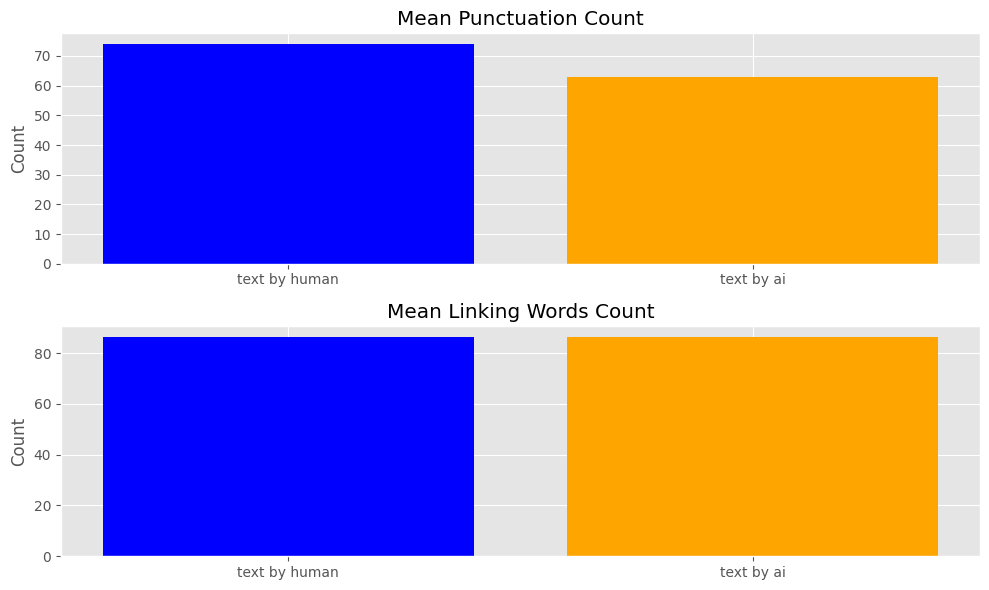

In [72]:
# Calculate the mean punctuation count and linking words count for human texts
human_mean_punctuation = df0_text.iloc[:]['punctuation_count'].mean()
human_mean_linking_words = df0_text.iloc[:]['linking_words_count'].mean()

# Calculate the mean punctuation count and linking words count for ai texts
ai_mean_punctuation = df1_ai.iloc[:]['punctuation_count'].mean()
ai_mean_linking_words = df1_ai.iloc[:]['linking_words_count'].mean()


plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.bar(['text by human', 'text by ai'], [human_mean_punctuation, ai_mean_punctuation], color=['blue', 'orange'])
plt.title('Mean Punctuation Count')
plt.ylabel('Count')


plt.subplot(2, 1, 2)
plt.bar(['text by human', 'text by ai'], [human_mean_linking_words, ai_mean_linking_words], color=['blue', 'orange'])
plt.title('Mean Linking Words Count')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [78]:
df_train_copy = df_train.copy()

df_train_copy.drop(['sentiment_score'], axis=1, inplace=True)
print(df_train_copy.head())
df_train_copy.fillna(0, inplace=True)

df_train_copy

                                                     text  source  \
7319    financial statement: habitat for humanity inte...       0   
229435  director alex graves has been giving some grea...       0   
757034  y the identical symbols and image of the not-q...       0   
46977   what it is to be human essay\n\nworld literatu...       0   
339918  more-in\n\nindia and the u.k. have many reason...       0   

        text_length  punctuation_count  linking_words_count  \
7319            652                263                  307   
229435          359                150                  182   
757034           67                 59                   25   
46977          1031                235                  407   
339918          230                 76                  110   

                                            word_features  \
7319    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
229435  [1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, ...   
757034  [0, 0, 0, 1, 0,

,text,source,text_length,punctuation_count,linking_words_count,word_features,punctuation_count_percentage,linking_words_count_percentage
7319,financial statement: habitat for humanity inte...,0,652,263,307,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",40.337423,47.085890
229435,director alex graves has been giving some grea...,0,359,150,182,"[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, ...",41.782730,50.696379
757034,y the identical symbols and image of the not-q...,0,67,59,25,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",88.059701,37.313433
46977,what it is to be human essay\n\nworld literatu...,0,1031,235,407,"[1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...",22.793404,39.476237
339918,more-in\n\nindia and the u.k. have many reason...,0,230,76,110,"[0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, ...",33.043478,47.826087
...,...,...,...,...,...,...,...,...
1219501,savage garden\n\nthe savage garden is a small ...,1,129,23,58,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...",17.829457,44.961240
1132662,the european union said on friday it had launc...,1,56,9,20,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",16.071429,35.714286
1245623,from the depths of the bowels of a mysterious ...,1,213,53,141,"[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, ...",24.882629,66.197183
1279971,"for most people, having a few extra pennies in...",1,433,115,192,"[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, ...",26.558891,44.341801


In [80]:

# # Function to tokenize text and remove stopwords
# def tokenize_text(text):
#     tokens = word_tokenize(text.lower())
#     stop_words = set(stopwords.words('english'))
#     return [token for token in tokens if token.isalpha() and token not in stop_words]

# # Tokenize all texts and count word occurrences
# all_words = [word for text in df_train_copy['text'] for word in tokenize_text(text)]
# word_counts = Counter(all_words)

# # Select the top 500 most common words as features
# top_words = [word for word, _ in word_counts.most_common(500)]

# def featurize_text(row):
#     # Tokenize text and calculate text length
#     tokens = tokenize_text(row['text'])
#     length_text = len(tokens)
    
#     # Calculate word features 
#     word_features = [1 if word in tokens else 0 for word in top_words]
    
#     # Get punctuation and linking words percentages from the dataframe
#     token_length = len(word_tokenize(row['text']))
#     punctuation_count = row['punctuation_count'] / token_length * 100 if token_length != 0 else 0
#     linking_words_count = row['linking_words_count'] / token_length * 100 if token_length != 0 else 0
    
#     return length_text, word_features, punctuation_count, linking_words_count


# tqdm.pandas(desc="Processing df_train_copy")
# # Apply the featurize_text function to the dataframe
# df_train_copy[['length_text', 'word_features', 'punctuation_count_percentage', 'linking_words_percentage']] = df_train_copy.progress_apply(featurize_text, axis=1).apply(pd.Series)
# df_train_copy


In [ ]:
#Function to calculate percentage of punctuation in a text
def calculate_punctuation_count(text):
   token_length = len(word_tokenize(text))
   return count_punctuation_marks(text) / token_length * 100 if token_length != 0 else 0

df_train_copy['punctuation_count_percentage'] = df_train_copy['text'].apply(calculate_punctuation_count)

#Function to calculate percentage of linking words in a text
def calculate_linking_words_count(text):
   token_length = len(word_tokenize(text))
   return count_linking_words(text) / token_length * 100 if token_length != 0 else 0

#Add a column to df0_text for linking words percentage
df_train_copy['linking_words_percentage'] = df_train_copy['text'].apply(calculate_linking_words_count)

In [74]:
df_train_copy

,text,source,punctuation_count,linking_words_count,word_features,punctuation_count_percentage,linking_words_count_percentage
7319,financial statement: habitat for humanity inte...,0,263,307,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",40.337423,47.085890
229435,director alex graves has been giving some grea...,0,150,182,"[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, ...",41.782730,50.696379
757034,y the identical symbols and image of the not-q...,0,59,25,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",88.059701,37.313433
46977,what it is to be human essay\n\nworld literatu...,0,235,407,"[1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...",22.793404,39.476237
339918,more-in\n\nindia and the u.k. have many reason...,0,76,110,"[0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, ...",33.043478,47.826087
...,...,...,...,...,...,...,...
1219501,savage garden\n\nthe savage garden is a small ...,1,23,58,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...",17.829457,44.961240
1132662,the european union said on friday it had launc...,1,9,20,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",16.071429,35.714286
1245623,from the depths of the bowels of a mysterious ...,1,53,141,"[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, ...",24.882629,66.197183
1279971,"for most people, having a few extra pennies in...",1,115,192,"[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, ...",26.558891,44.341801


Accuracy: 0.7716666666666666
Train Loss: 0.16076468375003725
Test Loss: 0.5988335609414779
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       426
           1       0.62      0.55      0.58       174

    accuracy                           0.77       600
   macro avg       0.72      0.71      0.71       600
weighted avg       0.77      0.77      0.77       600

Class-wise Metrics:
              precision    recall  f1-score     support
0              0.824719  0.861502  0.842710  426.000000
1              0.619355  0.551724  0.583587  174.000000
accuracy       0.771667  0.771667  0.771667    0.771667
macro avg      0.722037  0.706613  0.713148  600.000000
weighted avg   0.765163  0.771667  0.767564  600.000000


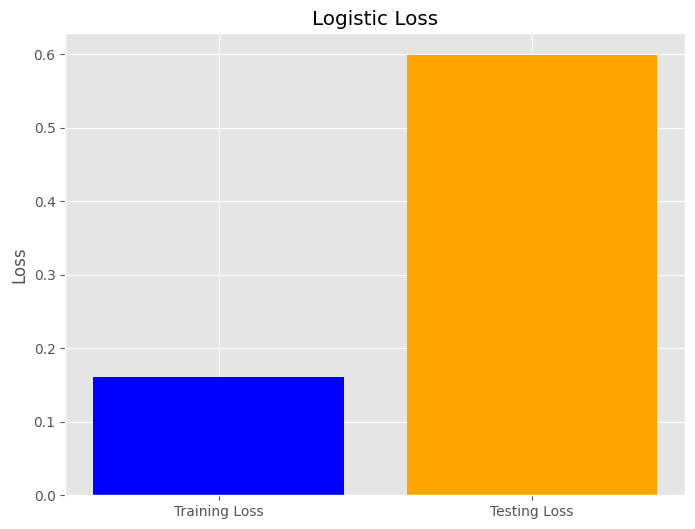

In [79]:
# Define features (word features, punctuation count, count of synonyms) and target variable
X = pd.DataFrame(df_train_copy['word_features'].tolist(), columns=top_words)
X['punctuation_count_percentage'] = df_train_copy['punctuation_count_percentage']
X['linking_words_percentage'] = df_train_copy['linking_words_count_percentage']
X['text_length'] = df_train_copy['text_length']
y = df_train_copy['source']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize SimpleImputer, Fit and transform the imputer on the feature matrix X, Initialize and train the Logistic Regression classifier
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
model = LogisticRegression(max_iter=2000, random_state=42)
model.fit(X_train_imputed, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_imputed)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
train_loss = log_loss(y_train, model.predict_proba(X_train_imputed)) # Calculate logistic loss for training and testing sets
test_loss = log_loss(y_test, model.predict_proba(X_test_imputed))
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

# Calculate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Parse the classification report to get individual class metrics
class_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
print("Class-wise Metrics:")
print(class_report_df)

# Plotting the Loss
loss_values = [train_loss, test_loss]
labels = ['Training Loss', 'Testing Loss']

plt.figure(figsize=(8, 6))
plt.bar(labels, loss_values, color=['blue', 'orange'])
plt.title('Logistic Loss')
plt.ylabel('Loss')
plt.show()

In [ ]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "text_classifier_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)